In [1]:
import numpy as np
import matplotlib.pyplot as pl
import time
from joblib import Parallel, delayed

In [2]:
c = 3e8
G = 6.67e-11
pi = np.pi
const = 96/5*pi**(8/3)*(G/c**3)**(5/3)

Specific arguments

In [3]:
f0 = 120
Mc = 3e-4* 2e30
f_max = 200
T_obs = 1e4
pad_len = int(340*T_obs) #~0.01 added length to resampled data
beta = const*f0**(8/3)*Mc**(5/3)

f_signal = 40*f_max
nt = round(f_signal*T_obs)
t = np.arange(nt)/f_signal
f_ratio = 25

In [4]:
beta

2.7439303219997145e-07

Generating signal and adding noise

In [5]:
frac_err = 1e-6
phi = -6*pi/5*f0*(1-8./3.*(1+frac_err)*beta*t)**(5/8)/((1+frac_err)*beta)
# phi = np.mod(phi,2*pi)
# signal = 1*np.exp(1j*phi)

# nh = 0
# noise = nh*np.random.normal(size = nt)
# data = signal + noise

In [6]:
def phi_expansion(t, beta, frac_err):
    temp0 = -6*pi*f0/5/beta*np.power(1-8/3*beta*t,5/8)
    temp1 = -6*pi*f0/5/beta*frac_err*(-1*beta*t)/np.power(1-8/3*beta*t, 3/8)
    return temp0 + temp1

ValueError: 
Analytic vs expansion of phi($eta$ + $\Delta$$eta$)
                             ^
Expected end of text, found '$'  (at char 29), (line:1, col:30)

<Figure size 432x288 with 1 Axes>

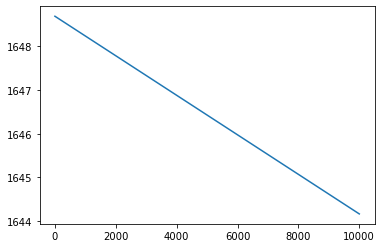

In [7]:
#Verifying correctness of Taylor expansion:

pl.plot(t[::10], phi[::10])
pl.plot(t[::10], phi_expansion(t[::10], beta, frac_err))
pl.title("Analytic vs expansion of phi($\beta$ + $\Delta$$\beta$)")
pl.show()

pl.plot(t[::10], phi[::10] - phi_expansion(t[::10], beta, frac_err))

In [8]:
tau = -3/5*(1-8/3*beta*t)**(5/8)/beta

In [9]:
# pl.plot(beta*tau)

In [10]:
def strobo(beta, data, f_ratio):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    f_new = f_signal/f_ratio
    
    new_t *= f_new #changes the frequency to the new downsampled frequency (approximately, not exactly)
    floor_t = np.floor(new_t) #For some reason floor works better than round. Take it to the nearest time index which are integers
    idx = np.nonzero(np.diff(floor_t)) #The step that downsamples
    resampled = data[idx]
    t_out = (new_t[idx])/f_new
    return (resampled, t_out)

In [11]:
temp_out, temp_time = strobo(beta, phi, 25)

In [9]:
from scipy.interpolate import splev, splrep
spl_time = splrep(t, temp_time)
spl_tau = splrep(t, tau)
pl.plot(t, spl)

ValueError: operands could not be broadcast together with shapes (3204405,) (80000000,) 

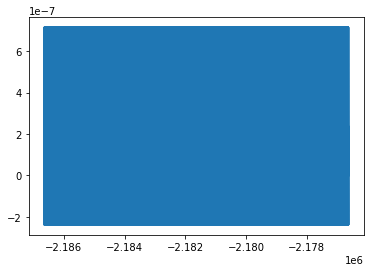

In [10]:
# monochromatic = 2*pi*f0*temp_time
# pl.plot(temp_time, monochromatic - temp_out)

In [22]:
frac_err = 1e-6
temp_out, temp_time = strobo(beta+frac_err*beta, phi, 25)

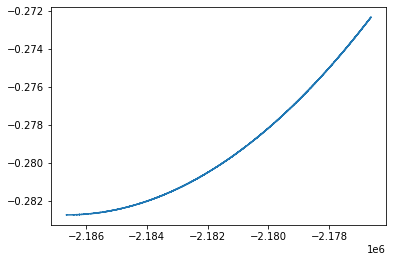

In [23]:
monochromatic = 2*pi*f0*(temp_time - temp_time[0]) + phi[0]
pl.plot(temp_time, monochromatic - temp_out)

In [24]:
def mathematica(tau, beta):
    A = 3**(8/5)*5**(-3/5)
    B = 3
    C = 8
    g = (A+B*(beta*tau)**8/5)/(C*(beta*tau)**8/5)
    return 2*pi*f0*tau*g*frac_err

In [14]:
temp_tau = -temp_time[0]
A = 3**(8/5)*5**(-3/5)
B = 3
C = 8
(A+B*(beta*temp_tau)**8/5)/(C*(beta*temp_tau)**8/5)

82.53974167573466

In [15]:
print('%.2E' % mathematica(-temp_time[0], beta))

1.36E+05


In [16]:
temp_time[0]

-2186642.259415817

In [25]:
resampled_residual = mathematica(temp_time, beta)

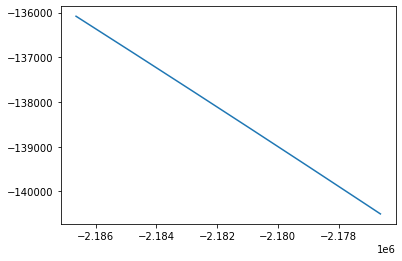

In [26]:
pl.plot(temp_time, resampled_residual)

In [15]:
tau = temp_time[2]
A = 3**(8/5)*5**(3/5)
B = 3
C = 8
g = (A+B*(beta*tau)**8/5)/(8*(beta*tau)**8/5)
print(2*pi*f0*tau*g*frac_err)

-935137.7405122331


In [16]:
# pl.plot(t, analytical(t, beta))

In [17]:
mathematica(temp_time[2], beta)

-136082.40170152584

In [21]:
phi0 = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
phi1 = -6*pi/5*f0*(1-8./3.*(beta+frac_err*beta)*t)**(5/8)/(beta+frac_err*beta)

In [ ]:
numerical = phi1 - phi0

In [18]:
def TE_1st(t, beta, frac_err, f0):
    temp0 = 2*pi*f0*frac_err
    temp1 = 3/5*np.power(1-8/3*beta*t,5/8)/beta
    temp2 = (-1+beta*t)/(1-8/3*beta*t)
    return temp0*temp1*temp2

In [19]:
analytical = TE_1st(t, beta, frac_err, f0)

In [20]:
pl.plot(t, phi1 - phi0)
pl.plot(t, -analytical)

NameError: name 'phi1' is not defined

In [ ]:
out0, time0 = strobo(beta, phi0, 25)
out1, time1 = strobo(beta, phi1, 25)

In [ ]:
pl.plot(time0, out1 - out0)

In [ ]:
(out1-out0)[0]

## Error with time instead of phase

In [21]:
def analytic_t_err(t, beta, frac_err):
    temp = (-1+beta*t)/(beta*(1-8/3*beta*t))
    return frac_err*temp

In [22]:
expected = analytic_t_err(t, beta, frac_err)

In [23]:
time0 = -3/5*(1-8/3*beta*t)**(5/8)/beta
time1 = -3/5*(1-8/3*(beta+frac_err*beta)*t)**(5/8)/(beta+frac_err*beta)

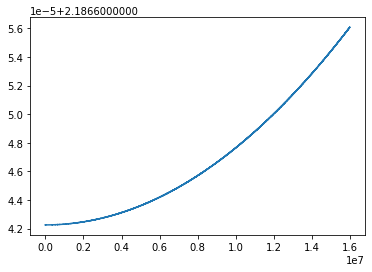

In [27]:
pl.plot((time1 - time0)[::5])

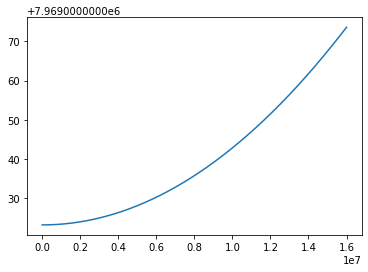

In [32]:
pl.plot((expected*time0)[::5])

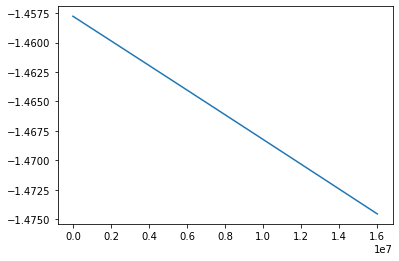

In [25]:
pl.plot(time1[::5] - (time0-expected)[::5])

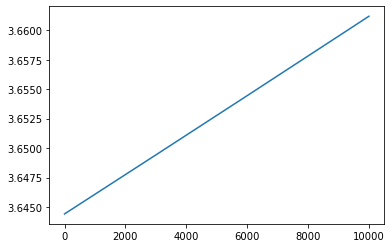

In [17]:
pl.plot(t[::5], -expected[::5])
# pl.plot(t[::5], (time1 - time0)[::5])

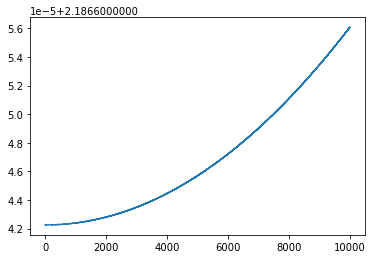

In [21]:
pl.plot(t[::5], (time1 - time0)[::5])